In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Downloads/archive (1)/lung_colon_image_set/colon_image_sets",  # Directory path should be outside the quotes
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['colon_aca', 'colon_n']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1]


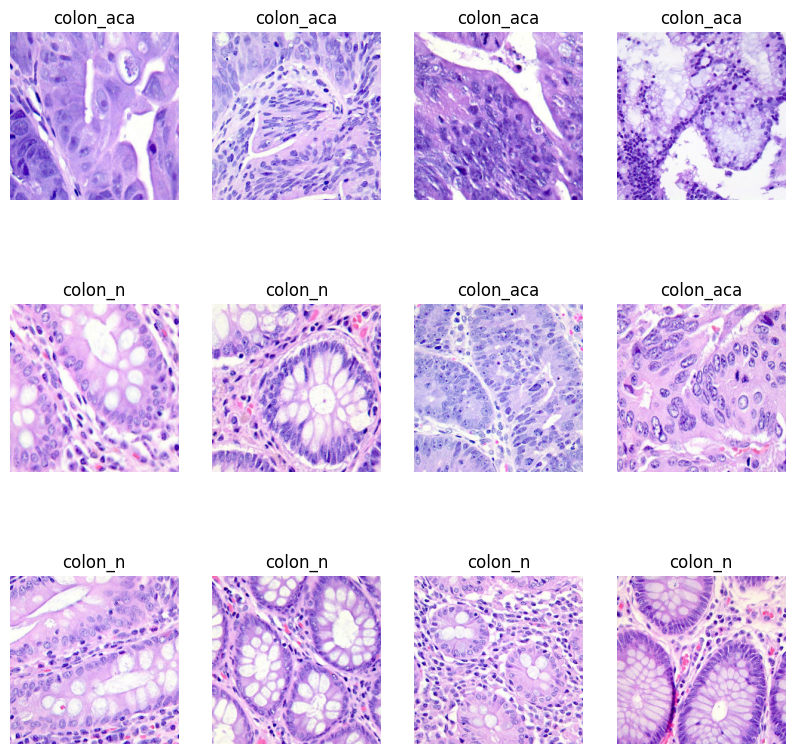

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

313

In [8]:
train_size = 0.8
len(dataset)*train_size

250.4

In [9]:
train_ds = dataset.take(250)
len(train_ds)

250

In [10]:
test_ds = dataset.skip(250)
len(test_ds)

63

In [11]:
val_size=0.1
len(dataset)*val_size

31.3

In [12]:
val_ds = test_ds.take(31)
len(val_ds)

31

In [13]:
test_ds = test_ds.skip(31)
len(test_ds)

32

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

250

In [17]:
len(val_ds)

31

In [18]:
len(test_ds)

32

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
# Load pre-trained DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_output_shape = base_model.output.shape[1:]
base_model.trainable = False
x = layers.GlobalAveragePooling2D()(base_model.output)
n_classes = len(dataset.class_names)


outputs = layers.Dense(n_classes, activation='softmax')(x)


In [31]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
250/250 [==============================] - 1024s 4s/step - loss: 0.2557 - accuracy: 0.8939 - val_loss: 0.5251 - val_accuracy: 0.7923
Epoch 2/5
250/250 [==============================] - 913s 4s/step - loss: 0.1601 - accuracy: 0.9409 - val_loss: 0.2306 - val_accuracy: 0.9123
Epoch 3/5
250/250 [==============================] - 893s 4s/step - loss: 0.1254 - accuracy: 0.9552 - val_loss: 0.5147 - val_accuracy: 0.8569
Epoch 4/5
250/250 [==============================] - 895s 4s/step - loss: 0.1013 - accuracy: 0.9639 - val_loss: 0.6288 - val_accuracy: 0.8478
Epoch 5/5
250/250 [==============================] - 926s 4s/step - loss: 0.0998 - accuracy: 0.9648 - val_loss: 0.7452 - val_accuracy: 0.8296


In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [43]:
EPOCHS = len(acc)  # Assuming that acc is the array containing accuracy values


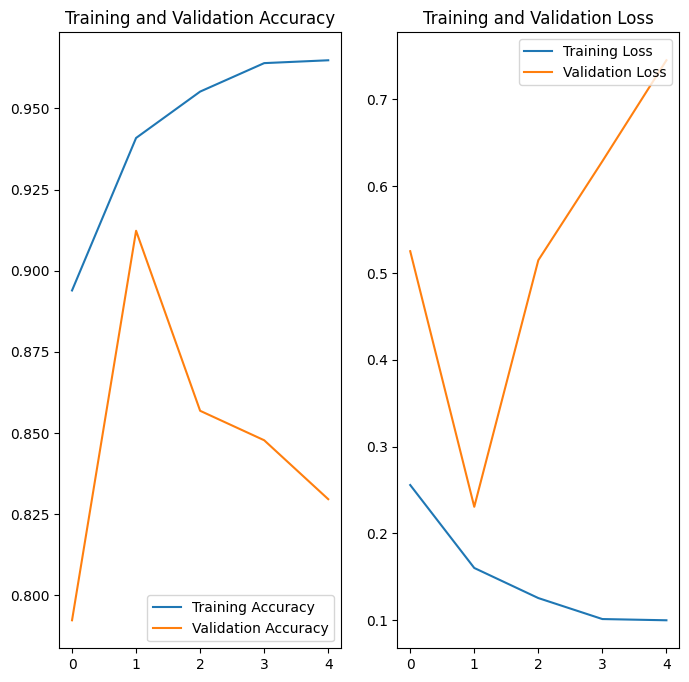

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc[:EPOCHS], label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc[:EPOCHS], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss[:EPOCHS], label='Training Loss')
plt.plot(range(EPOCHS), val_loss[:EPOCHS], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: colon_n
1/1 [==============================] - 2s 2s/step
predicted label: colon_n


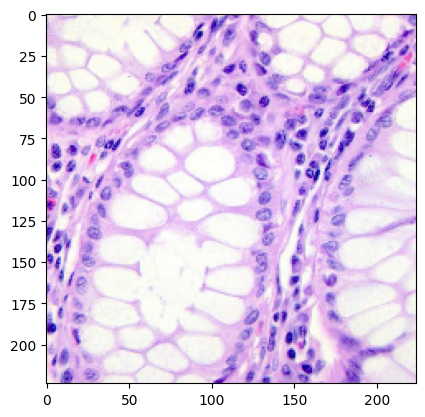

In [45]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 182ms/step


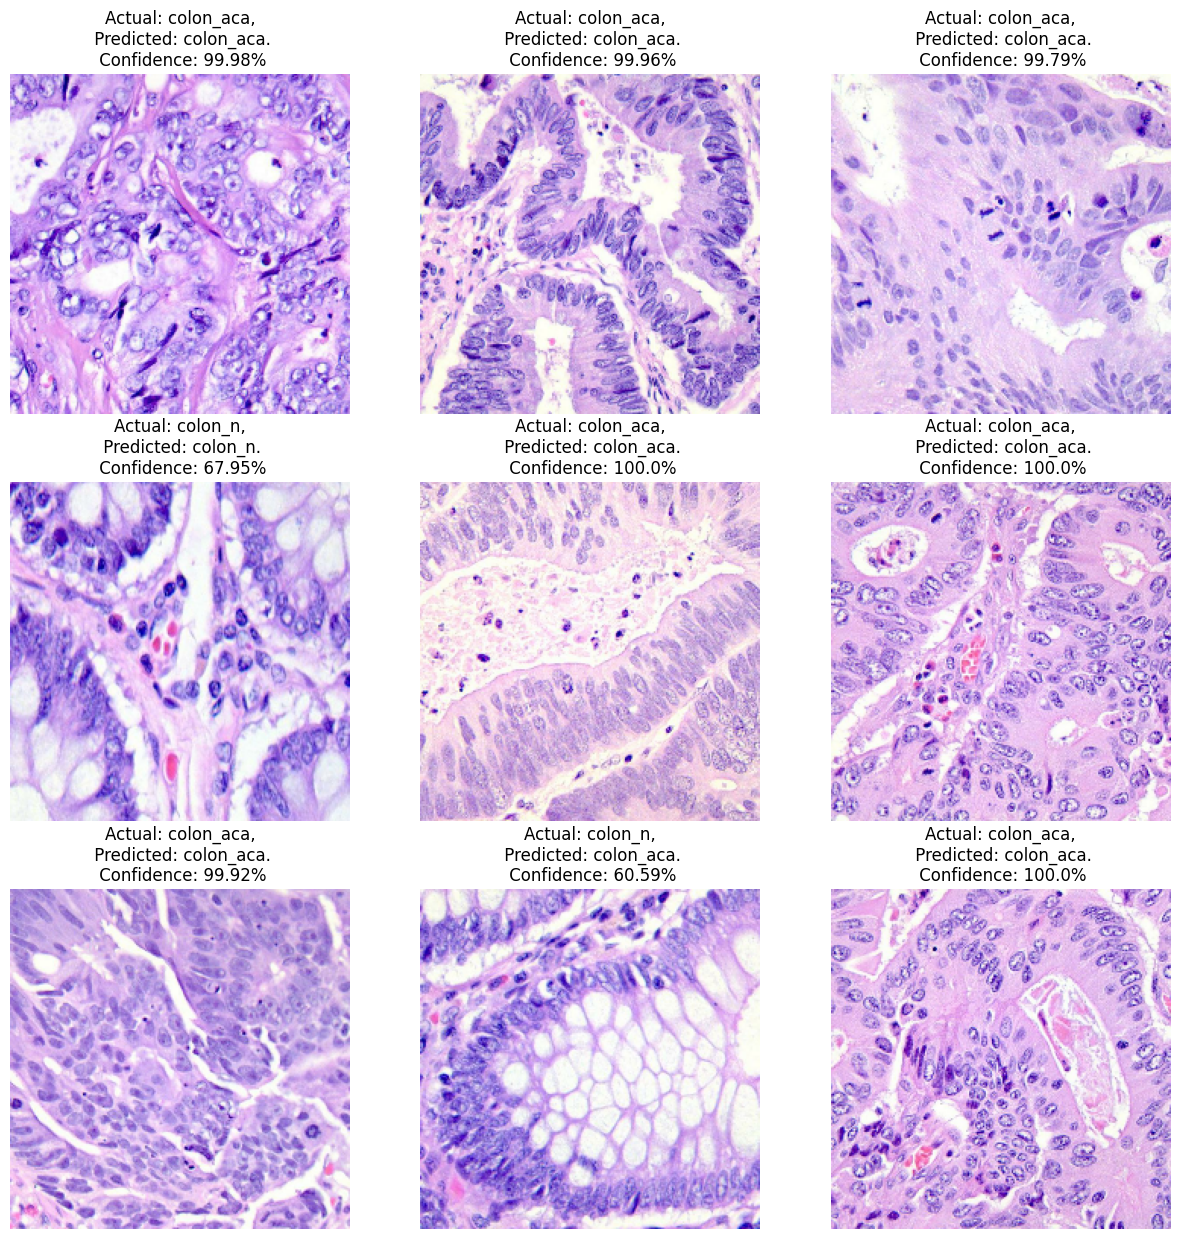

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(20):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 3s 3s/step


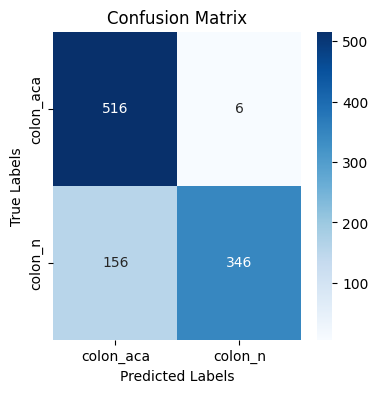

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the trained model and test dataset
# model = ...
# test_ds = ...

# Get true labels and predictions
true_labels = []
predictions = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    true_labels_batch = labels_batch.numpy()
    true_labels.extend(true_labels_batch)
    predictions.extend(predicted_labels_batch)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = dataset.class_names

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [50]:
from sklearn.metrics import classification_report


# Get true labels and predictions
true_labels = []
predictions = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    true_labels_batch = labels_batch.numpy()
    true_labels.extend(true_labels_batch)
    predictions.extend(predicted_labels_batch)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=dataset.class_names)

print(report)


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

   colon_aca       0.77      0.99      0.86       522
     colon_n       0.98      0.69      0.81       502

    accuracy                           0.84      1024
   macro avg       0.88      0.84      0.84      1024
weighted avg       0.87      0.84      0.84      1024



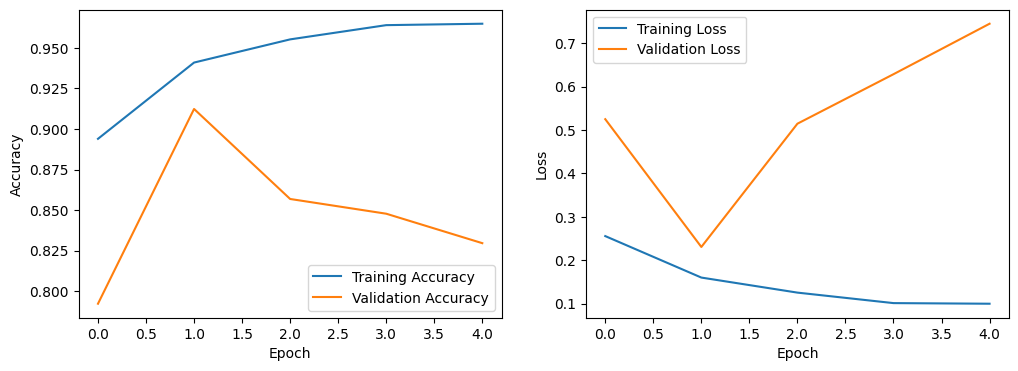

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [57]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels and predictions
true_labels = []
predictions = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    true_labels_batch = labels_batch.numpy()
    true_labels.extend(true_labels_batch)
    predictions.extend(predicted_labels_batch)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print(conf_matrix)


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

   colon_aca       0.77      0.99      0.86       522
     colon_n       0.98      0.69      0.81       502

    accuracy                           0.84      1024
   macro avg       0.88      0.84      0.84      1024
weighted avg       0.87      0.84      0.84      1024

[[516   6]
 [156 346]]


In [ ]:
model.